In [ ]:
import numpy as np
import pandas as pd

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-for-financial-news' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-financial-news


In [ ]:
import os
os.listdir(path)

['all-data.csv', 'FinancialPhraseBank']

In [ ]:
df = pd.read_csv(path+"/all-data.csv", encoding='latin1', index_col=False)

In [ ]:
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
df.columns = ["target", "text"]

In [ ]:
df = df.iloc[:, [1, 0]]

In [ ]:
df.head()

,text,target
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive


In [ ]:
df.shape

(4845, 2)

In [ ]:
df.isna().sum()

,0
text,0
target,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
df['target'] = encoder.fit_transform(df['target'])

In [ ]:
# df.drop(columns=['text'], inplace=True)

In [ ]:
df

,text,target
0,Technopolis plans to develop in stages an area...,1
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,2
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,0
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4842,Operating profit fell to EUR 35.4 mn from EUR ...,0
4843,Net sales of the Paper segment decreased to EU...,0


In [ ]:
# we have to keep in mind that the data is in uneven distribution
print(f"{(df['target'].value_counts()[0]/4845)*100:.2f}") # negative
print(f"{(df['target'].value_counts()[1]/4845)*100:.2f}") # neutral
print(f"{(df['target'].value_counts()[2]/4845)*100:.2f}") # positive

12.47
59.40
28.13


In [ ]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# negative --> 0
# neutral --> 1
# positive --> 2

In [ ]:
# Text Preprocessing (Retain logic/stopwords)
import re
def clean_text(text):
    # Lowercase to normalize "Not" and "not"
    text = text.lower()
    # Remove URLs and HTML tags
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>', '', text)
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
# splitting data (stratified)
from sklearn.model_selection import train_test_split

# --- STEP 1: Separate the Test Set (10% of total) ---
# We use stratify=df['target'] to maintain class proportions
df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['target']
)

In [ ]:
# --- Verification ---
def check_splits(sets):
    for name, data in sets.items():
        print(f"\n--- {name} Set ---")
        print(f"Size: {len(data)} samples")
        print("Proportions (%):")
        print(data['target'].value_counts(normalize=True) * 100)

In [ ]:
check_splits({"Train": df_train, "Test": df_test})


--- Train Set ---
Size: 3876 samples
Proportions (%):
target
1    59.391125
2    28.147575
0    12.461300
Name: proportion, dtype: float64

--- Test Set ---
Size: 969 samples
Proportions (%):
target
1    59.442724
2    28.070175
0    12.487100
Name: proportion, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization: TF-IDF with (1, 3) n-grams
# ---------------------------------------------------------
# Note: min_df=2 ignores words/phrases that appear only once, reducing noise.
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=10000)

# IMPORTANT: Fit ONLY on training data to prevent data leakage
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [ ]:
# I will use Logistic Regression with multinomial
from sklearn.linear_model import LogisticRegression
# Balanced Multinomial Logistic Regression
# ---------------------------------------------------------
lg = LogisticRegression(
    class_weight='balanced',
    C=0.1,
    solver='lbfgs',
    max_iter=1000
)

In [ ]:
# model training

lg.fit(X_train, df_train['target'])

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Evaluation
# ---------------------------------------------------------
train_pred = lg.predict(X_train)
test_pred = lg.predict(X_test)

print("Train accuracy: ", accuracy_score(df_train['target'], train_pred))
print("Test accuracy: ", accuracy_score(df_test['target'], test_pred))

print("------------Classification Report----------------")
print(classification_report(df_test['target'], test_pred))

Train accuracy:  0.8090815273477813
Test accuracy:  0.7409700722394221
------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.55      0.67      0.61       121
           1       0.81      0.84      0.82       576
           2       0.69      0.56      0.62       272

    accuracy                           0.74       969
   macro avg       0.68      0.69      0.68       969
weighted avg       0.74      0.74      0.74       969



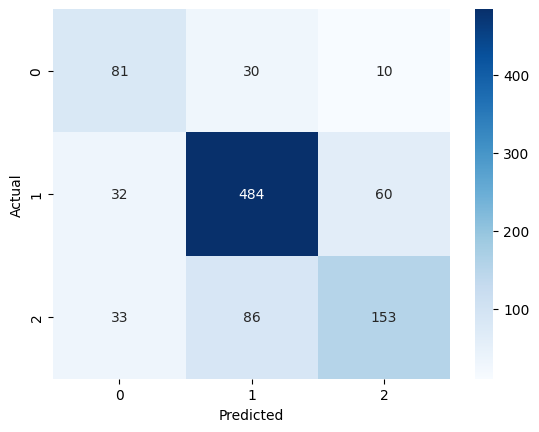

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['target'], test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib

# Bundle the components
model_artifact = {
    'vectorizer': vectorizer,
    'model': lg,
    'classes': lg.classes_
}

# Dump with compression (3 is a good balance between speed and size)
joblib.dump(model_artifact, 'sentiment_analysis_v1.joblib', compress=3)

print("Model and Vectorizer successfully saved to 'sentiment_analysis_v1.joblib'")

Model and Vectorizer successfully saved to 'sentiment_analysis_v1.joblib'


In [ ]:
# Lets move on to LSTM Based implementation

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re

class DatasetPrepare(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len=64):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

        # Build Vocab is not provided
        if vocab is None:
            self.vocab = self.build_vocab(texts)
        else:
            self.vocab = vocab

    def build_vocab(self, texts):
        # 1. Tokenize all the words
        all_tokens = []
        for text in texts:
            tokens = self.tokenize(text)
            all_tokens.extend(tokens)

        # 2. keep words appearing > 1 time
        word_counts = Counter(all_tokens)
        unique_words = [word for word, count in word_counts.items() if count >= 2]

        # 3. Create mapping: WORD -> ID
        # 0 is reserved for Padding, 1 for Unknown
        vocab = {word : idx + 2 for idx, word in enumerate(unique_words)}
        vocab['<PAD>'] = 0
        vocab['<UNK>'] = 1
        return vocab

    def tokenize(self, text):
        #  Simple regex for tokenizer: lowercase & remove special chars
        text = text.lower()
        return re.findall(r'\w+', text)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # get raw text and label
        text = self.texts[idx]
        label = self.labels[idx]

        # tokenize
        tokens = self.tokenize(text)

        # Convert to Integers (Vectorization)
        # Use <UNK> (id = 1) if word not in vocab
        token_ids = [self.vocab.get(token, 1) for token in tokens]

        # capture actual length
        seq_len = min(len(token_ids), self.max_len)

        # Clip length if it exceeds max_len (to avoid index errors)
        if seq_len > self.max_len:
            seq_len = self.max_len

        # pad or truncate to max Length
        if len(token_ids) < self.max_len:
            # pad with 0
            token_ids = token_ids + [0] * (self.max_len - len(token_ids))
        else:
            # truncate
            token_ids = token_ids[:self.max_len]

        return (
            torch.tensor(token_ids, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
            torch.tensor(seq_len, dtype=torch.long)
        )

In [ ]:
# Creating the LSTM  Model
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class MyLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=32, output_dim=3):
        super(MyLSTM, self).__init__()

        # Embedding layer
        # padding_idx = 0 ensures that the model ignores the 0s we added for the mask
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0 )

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=1,             # Kept to 1 for small data
            batch_first=True,
            bidirectional=True
        )

        # 3. Output Head
        # input is hidden_dim * 2 (Forward + Backward state)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, text, text_lengths):
        # text shape = [batch_size, seq_len]

        # embedding shape = [batch_size, seq_len, embed_dim]
        embedded = self.embedding(text)

        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # lstm output
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # we will use the final hidden layer of the last layer
        # concatenate the final forward and backwar hidden states
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        hidden_cat = self.dropout(hidden_cat)

        return self.fc(hidden_cat)

In [ ]:
# training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load Data
# The dataset usually has no headers.
# Col 0: Sentiment (positive/neutral/negative), Col 1: Sentence
df = pd.read_csv(path + '/all-data.csv', names=['sentiment', 'text'], encoding='latin-1')

# 2. Map Labels to Integers
# Standard mapping: Negative=0, Neutral=1, Positive=2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['sentiment'].map(label_map)

# 3. Stratified Split (80% Train, 10% Val, 10% Test)
# First split: 80% Train, 20% Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_id'] # CRITICAL: Maintains class balance
)

# Second split: Split the 20% Temp into Val (10%) and Test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label_id']
)

# 4. Extract Lists for your Dataset Class
train_texts = train_df['text'].tolist()
train_labels = train_df['label_id'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label_id'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label_id'].tolist()

print(f"Train Size: {len(train_texts)}")
print(f"Val Size:   {len(val_texts)}")
print(f"Test Size:  {len(test_texts)}")

Train Size: 3876
Val Size:   485
Test Size:  485


Starting Training...
Epoch 01 | Loss: 0.938 | Train Acc: 57.35% | Val Acc: 63.51% | Val F1: 0.352
Epoch 02 | Loss: 0.818 | Train Acc: 64.53% | Val Acc: 66.39% | Val F1: 0.461
Epoch 03 | Loss: 0.724 | Train Acc: 69.04% | Val Acc: 68.66% | Val F1: 0.498
Epoch 04 | Loss: 0.613 | Train Acc: 73.97% | Val Acc: 69.90% | Val F1: 0.555
Epoch 05 | Loss: 0.493 | Train Acc: 79.77% | Val Acc: 68.45% | Val F1: 0.522


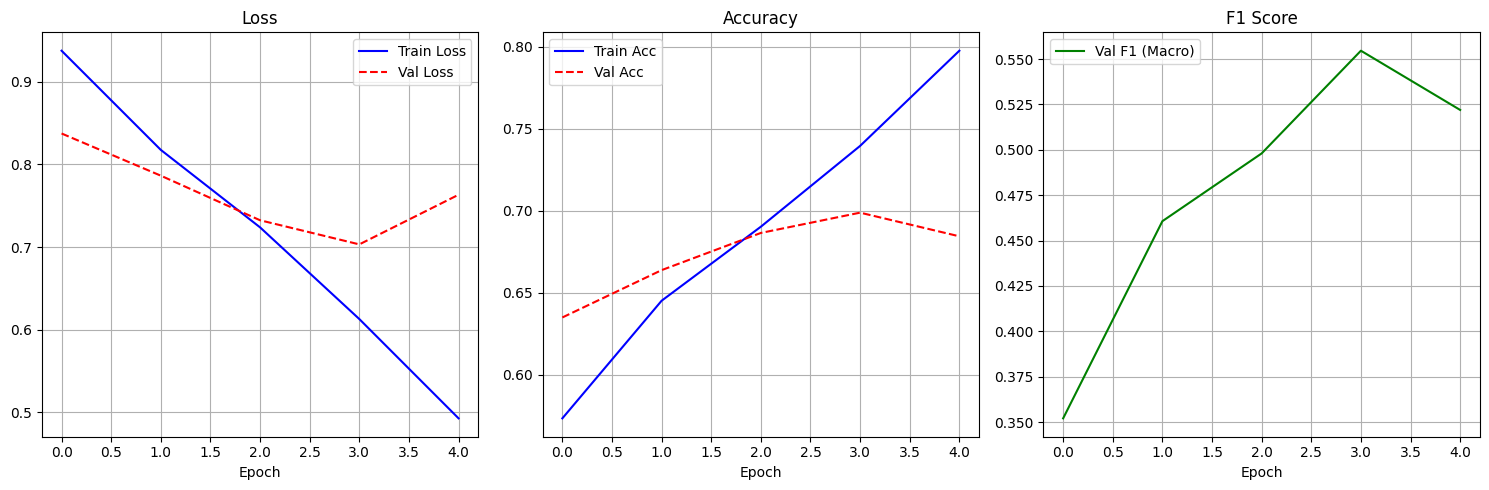

In [ ]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support # NEW IMPORT

# 1. Setup Storage (Added Precision, Recall, F1)
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset & Loader Setup
train_ds = DatasetPrepare(train_texts, train_labels)
val_ds = DatasetPrepare(val_texts, val_labels, vocab=train_ds.vocab)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Model Instance
VOCAB_SIZE = len(train_ds.vocab)
model = MyLSTM(vocab_size=VOCAB_SIZE, output_dim=3)
model = model.to(device)

# Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

# Training Loop
EPOCHS = 5

print("Starting Training...")

for epoch in range(EPOCHS):
    # ==========================
    # TRAINING PHASE
    # ==========================
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for text, label, lengths in train_loader:
        text = text.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        predictions = model(text, lengths)
        loss = criterion(predictions, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = torch.max(predictions, 1)
        train_correct += (pred == label).sum().item()
        train_total += label.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # ==========================
    # VALIDATION PHASE
    # ==========================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Storage for Scikit-Learn Metrics
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, label, lengths in val_loader:
            text, label = text.to(device), label.to(device)

            predictions = model(text, lengths)
            loss = criterion(predictions, label)

            val_loss += loss.item()
            _, pred = torch.max(predictions, 1)
            val_correct += (pred == label).sum().item()
            val_total += label.size(0)

            # Store for metric calculation (Move to CPU)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Calculate Precision, Recall, F1 (Using Macro Average for Imbalance)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro', # 'macro' treats all classes equally, 'weighted' favors majority
        zero_division=0
    )

    # ==========================
    # STORE METRICS
    # ==========================
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    # Logging
    print(f"Epoch {epoch+1:02} | "
          f"Loss: {avg_train_loss:.3f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Val Acc: {val_acc*100:.2f}% | "
          f"Val F1: {f1:.3f}")

# ==========================
# VISUALIZATION BLOCK
# ==========================
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc', color='blue')
plt.plot(history['val_acc'], label='Val Acc', color='red', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Val F1 (Macro)', color='green')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
!pip install transformers evaluate datasets accelerate

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

# 1. Load Data
# Replace 'path' with your actual path string if needed
df = pd.read_csv(path+'/all-data.csv', names=['sentiment', 'text'], encoding='latin-1')

# 2. Clean and Map Labels
# Ensure consistency
df['sentiment'] = df['sentiment'].str.lower().str.strip()

# Map to integers: Negative=0, Neutral=1, Positive=2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

# Drop any errors (NaNs)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# 3. Split Data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# 4. Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")

In [21]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

# Tokenize
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# Data Collator (handles dynamic padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [22]:
import evaluate
from transformers import AutoModelForSequenceClassification

# 1. Setup Metrics
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 'macro' average is best for imbalanced financial data
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]

    return {"f1": f1, "accuracy": acc}

# 2. Load Model
# num_labels=3 is REQUIRED for Neg/Neu/Pos
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3,
    id2label={0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"},
    label2id={"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bert_financial_finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # 3 Epochs is usually standard for BERT
    weight_decay=0.01,
    eval_strategy="epoch",     # Evaluate at end of every epoch
    save_strategy="epoch",           # Save checkpoint at end of every epoch
    load_best_model_at_end=True,     # Load best model when finished
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Starting Training...")
trainer.train()

/tmp/ipython-input-1543946921.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Training...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.396702,0.823978,0.838144
2,No log,0.429727,0.832238,0.837113
3,0.458100,0.476846,0.831021,0.842268


TrainOutput(global_step=729, training_loss=0.3626336619687178, metrics={'train_runtime': 206.8521, 'train_samples_per_second': 56.214, 'train_steps_per_second': 3.524, 'total_flos': 351866918018952.0, 'train_loss': 0.3626336619687178, 'epoch': 3.0})

In [25]:
import torch

def predict_real_news(text, model, tokenizer):
    # 1. Prepare the text (same processing as training)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    )

    # 2. Move inputs to the same device as the model (GPU/CPU)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Predict
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Get Probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # 5. Get Label
    # Our map: 0 -> Negative, 1 -> Neutral, 2 -> Positive
    id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
    pred_idx = torch.argmax(probs).item()
    confidence = probs[0][pred_idx].item()

    return id2label[pred_idx], confidence

print("Prediction function ready.")

Prediction function ready.


In [26]:
# Real-world examples gathered from financial news styles
real_news_data = [
    # 1. Clear Negative (Layoffs)
    "Spotify announces plans to cut 17% of its workforce to reduce costs and improve efficiency.",

    # 2. Clear Positive (Earnings Beat)
    "NVIDIA reports record revenue of $18.1 billion, up 206% from a year ago, beating analyst expectations.",

    # 3. Neutral (Standard Regulatory/Fed News)
    "The Federal Reserve kept its benchmark interest rate unchanged in the range of 5.25% to 5.50%.",

    # 4. Tricky Negative (Lawsuit/Fine)
    "Regulators fined the bank $150 million for failing to monitor illicit trading activities.",

    # 5. Tricky Positive (Loss narrowed - traditionally positive in finance)
    "The company's operating loss narrowed significantly to $5 million compared to $20 million last year."
]

print("-" * 60)
print(f"{'NEWS HEADLINE':<50} | {'PREDICTION':<10} | {'CONFIDENCE'}")
print("-" * 60)

for headline in real_news_data:
    sentiment, conf = predict_real_news(headline, model, tokenizer)

    # Truncate headline for cleaner printing
    display_text = (headline[:47] + '...') if len(headline) > 47 else headline

    print(f"{display_text:<50} | {sentiment:<10} | {conf*100:.2f}%")

------------------------------------------------------------
NEWS HEADLINE                                      | PREDICTION | CONFIDENCE
------------------------------------------------------------
Spotify announces plans to cut 17% of its workf... | NEGATIVE   | 44.99%
NVIDIA reports record revenue of $18.1 billion,... | POSITIVE   | 95.38%
The Federal Reserve kept its benchmark interest... | NEUTRAL    | 92.98%
Regulators fined the bank $150 million for fail... | NEGATIVE   | 72.61%
The company's operating loss narrowed significa... | NEGATIVE   | 76.01%


In [27]:
import joblib
from google.colab import files

# 1. Save the model state dict (weights)
# We use .cpu() to ensure weights are not bound to GPU memory when loaded later
joblib.dump(model.state_dict(), 'bert_financial_model.joblib')

# 2. Save Config (To remember 3 classes)
config = {
    'model_name': 'bert-base-uncased',
    'max_len': 128,
    'n_classes': 3
}
joblib.dump(config, 'bert_config.joblib')

print("Files saved. Downloading...")
files.download('bert_financial_model.joblib')
files.download('bert_config.joblib')

Files saved. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>